<div style="background-color: beige; padding: 10px;">
<p style='font-size: 22px; text-align: right;'><strong>Stephanie Dragoi and Victor Matsumoto</strong></p>
<p style='font-size: 22px; text-align: right;'><strong>DUE 20231026</strong></p>
<p style='font-size: 22px; text-align: right;'><strong>MLR Project- Used Car Pricing Model</strong></p>
</div>

# Introduction and Car Selection

# Munging and Field Engineering

The torque column had conflicting units; most observations were entered in Nm@rpm, but a few were entered in kgm@rpm, which we changed to Nm@rpm. Some of the torques were given in the format torque@[range of rpms], which we changed to torque@lower_rpm. <br>
<br>
For the engine, max_power, and torque fields, we changed all the values to be expressed to the one's place (ex. 65.01 became 65). <br>
<br>
<br>
One of the models was listed as Tata Indigo VS, which is not a valid model, so we dropped this observation, being unable to match its specifications to the Indigo CS, which was one model to which 'VS' could have plausibly been referring. Three additional Tata Indigo observations were dropped because their model was listed simply as "TDI," which could refer to the quite different Tata Indigo LX (TDI): 2008 - 2011, Tata Indigo LX (TDI) BS-III: 2008 - 2011, Tata Indigo CS LE (TDI) BS-III: 2008 - 2011, or Tata Indigo CS LS (TDI) BS-III: 2008 - 2011. <br>
<br>
Since the engine, max_power, and torque fields give very similar information, they were combined into one field called engine_max_power_torque, with data in this field being in the format "engine max_power torque@x_rpm". However, ultimately, our engineered field showed that choosing engine, max_power, or torque for calculations would be sufficient rather than attempting to use all three, since they essentially measure the same thing.<br>
<br>
Since many of the model names were extremely specific, two fields were created to replace the original model_contd field: one called model_gen, with the general name of the model, such as "CS" for "CS eGLS BS IV," and one with the original, ultra-specific model name, adjusted in a 2-3 cases to omit information like trim. <br>
<br>
Three fields were dropped since all the observations had the same value: make, transmission, and seats. <br>

# Step 4: Import Libraries

In [11]:
# Import all necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.compat import lzip

# Step 5: Python Functions

In [12]:
# Define useful functions including regression_performance, calculate_vif

def regression_performance(model, X, y):
 yhat = model.predict(X)
 mse = mean_squared_error(y, yhat)
 mae = mean_absolute_error(y, yhat)
 mape = np.mean(np.abs(y - yhat) / y) * 100 # mean absolute pct. error
 df_performance_summary = pd.DataFrame(
 {"MSE": mse, "MAE": mae, "MAPE": mape}, index=[0])
 return df_performance_summary

# Function to return a dataframe showing the VIF for each explanatory variable:
# Note that the explanatory variables are in a dataframe called Xdataframe.
def calculate_vif(Xdataframe):
 temp_df = pd.DataFrame()
 temp_df["column name"] = Xdataframe.columns
 temp_df["VIF"] = [variance_inflation_factor(Xdataframe.values, k)
 for k in range(len(Xdataframe.columns))]
 return temp_df

# Step 6: Dataframe Summary Statistics

In [13]:
# read csv and describe
df = pd.read_csv('Munged and Engineered Car data.csv')
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,284.0,2010.904930,2.944980,2003.000000,2009.00000,2011.00000,2013.00000,2018.0000
asking_price,284.0,8935.902465,4133.273001,2000.000000,5699.96250,8500.00000,11424.95000,22500.0000
miles_driven,284.0,59907.544600,27672.469662,7454.545455,42708.33333,55909.09091,74545.45455,168348.4848
num_previous_owners,284.0,1.665493,0.735812,1.000000,1.00000,2.00000,2.00000,4.0000


# Step 7: Variable Types and Missing Data

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284 entries, 0 to 283
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   model                    284 non-null    object 
 1   model_gen                284 non-null    object 
 2   model_spec               284 non-null    object 
 3   year                     284 non-null    int64  
 4   asking_price             284 non-null    float64
 5   miles_driven             284 non-null    float64
 6   fuel                     284 non-null    object 
 7   seller_type              284 non-null    object 
 8   num_previous_owners      284 non-null    int64  
 9   mileage                  284 non-null    object 
 10  engine                   284 non-null    object 
 11  max_power                284 non-null    object 
 12  torque                   284 non-null    object 
 13  engine_max_power_torque  284 non-null    object 
dtypes: float64(2), int64(2), o

Most fields are of type object, with a few being int64 or float64. There is no missing data, since all of it has been handled using imputation (see step 8).

# Step 8: Missing Data Treatment

Missing data was treated in the spreadsheet using imputation. 5 observations of make/model Tata Indica DLS, 1 observation of make/model Tata Indica DLX, 5 observations of make/model Tata Indica Vista Aqua 1.3 Quadrajet (ABS), and 2 observations of make/model Tata Indica Vista Quadrajet LS were missing values for the following fields: <br>
* mileage
* engine
* max_power
* torque
* seats
<br>
<br>
The missing values were imputed using information from the websites CarFolio and CarWale, which provided information for the above fields based on make and model.

# Step 9: Categorical Conversion

In [15]:
# Convert all variables that are logically categorical, except for model year, into true categories
# Code from official Pandas documentation on categorical data

categorical_columns = ['model', 'model_gen', 'model_spec','fuel','seller_type','num_previous_owners','mileage','engine','max_power','torque']
df[categorical_columns] = df[categorical_columns].astype('category')

# Step 10: Explanatory/Target Split

In [16]:
# split data into explanatory matrix (X) and target column (y)

X = df.drop(['asking_price'], axis = 1)
y = df['asking_price']

# Step 11: Dummy Variables for Categorical Values

In [17]:
# Perform one-hot encoding for all categorical values

X = X.drop(['max_power', 'torque', 'engine_max_power_torque'], axis = 1)
print(X.columns)
# Perform one-hot encoding for all categorical values
X_encoded = pd.get_dummies(
    X,
    columns=X.select_dtypes(include=["object","category"]).columns.tolist(),
    drop_first=True
)
X_encoded = X_encoded.drop(['year','miles_driven'], axis = 1)

# Combine the original columns and one-hot encoding columns
X = pd.concat([X, X_encoded], axis=1)
X

Index(['model', 'model_gen', 'model_spec', 'year', 'miles_driven', 'fuel',
       'seller_type', 'num_previous_owners', 'mileage', 'engine'],
      dtype='object')


,model,model_gen,model_spec,year,miles_driven,fuel,seller_type,num_previous_owners,mileage,engine,...,mileage_19.4 kmpl,mileage_22.3 kmpl,mileage_23.03 kmpl,mileage_23.57 kmpl,mileage_23.7 km/kg,mileage_25.0 kmpl,engine_1193 CC,engine_1248 CC,engine_1396 CC,engine_1405 CC
0,Indigo,eCS,CR4,2011,52381.22727,Diesel,Individual,1,23.57 kmpl,1396 CC,...,0,0,0,1,0,0,0,0,1,0
1,Indigo,eCS,eCS CR4,2011,43484.84848,Diesel,Individual,2,23.57 kmpl,1396 CC,...,0,0,0,1,0,0,0,0,1,0
2,Indigo,eCS,eCS CR4,2011,43484.84848,Diesel,Individual,2,23.57 kmpl,1396 CC,...,0,0,0,1,0,0,0,0,1,0
3,Indigo,eCS,eCS CR4,2011,31060.60606,Diesel,Individual,2,23.57 kmpl,1396 CC,...,0,0,0,1,0,0,0,0,1,0
4,Indigo,eCS,eCS CR4,2011,108712.12120,Diesel,Individual,2,23.57 kmpl,1396 CC,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,Indica,Vista,Vista Terra 1.4 TDI,2011,49696.96970,Diesel,Individual,1,17.0 kmpl,1405 CC,...,0,0,0,0,0,0,0,0,0,1
280,Indica,Vista,Vista Terra Quadrajet 1.3L,2010,74545.45455,Diesel,Individual,2,18.0 kmpl,1248 CC,...,0,0,0,0,0,0,0,1,0,0
281,Indica,Vista,Vista Terra Quadrajet 1.3L,2010,62121.21212,Diesel,Individual,2,18.0 kmpl,1248 CC,...,0,0,0,0,0,0,0,1,0,0
282,Indica,Vista,Vista Terra Quadrajet 1.3L,2011,54045.45455,Diesel,Individual,1,18.0 kmpl,1248 CC,...,0,0,0,0,0,0,0,1,0,0


# Step 12: Preliminary EDA

## Create Histograms and Modified Boxplots or Bar Graphs for All Fields

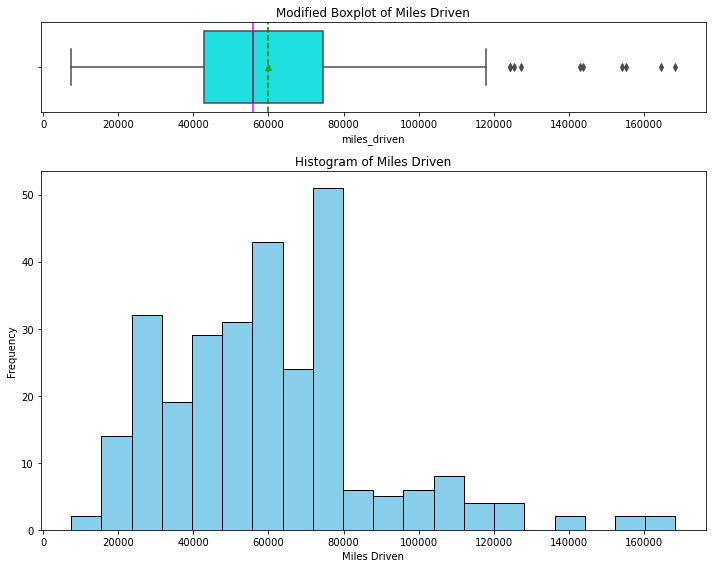

In [19]:

# Create a figure and a grid of subplots with 2 rows and 1 column
fig, (ax_box, ax_hist) = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={"height_ratios": [0.2, 0.8]})

# Create a modified boxplot for 'miles_driven'
sns.boxplot(x=df['miles_driven'], ax=ax_box, showmeans=True, color='cyan')
ax_box.set_title('Modified Boxplot of Miles Driven')
ax_box.grid(False)  # Remove grid lines

# Add mean and median lines to the boxplot
ax_box.axvline(np.mean(df['miles_driven']), color='green', linestyle='--')
ax_box.axvline(np.median(df['miles_driven']), color='magenta', linestyle='-')

# Create a histogram for 'miles_driven'
ax_hist.hist(df['miles_driven'], bins=20, color='skyblue', edgecolor='black')
ax_hist.set_title('Histogram of Miles Driven')
ax_hist.set_xlabel('Miles Driven')
ax_hist.set_ylabel('Frequency')
ax_hist.grid(False)  # Remove grid lines

# Adjust the layout of subplots for better spacing
plt.tight_layout()

# Show the subplots
plt.show()


EXPLAIN THIS
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

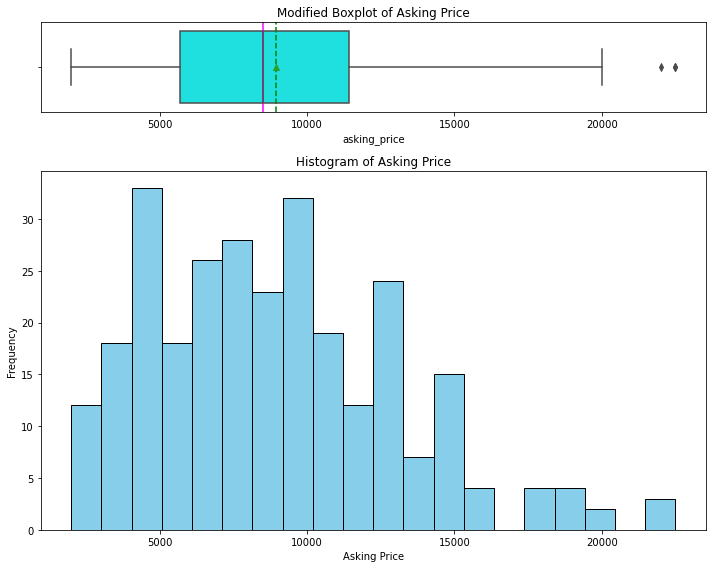

In [20]:
# Create a figure and a grid of subplots with 2 rows and 1 column
fig, (ax_box, ax_hist) = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={"height_ratios": [0.2, 0.8]})

# Create a modified boxplot for 'asking_price'
sns.boxplot(x=df['asking_price'], ax=ax_box, showmeans=True, color='cyan')
ax_box.set_title('Modified Boxplot of Asking Price')
ax_box.grid(False)  # Remove grid lines

# Add mean and median lines to the boxplot
ax_box.axvline(np.mean(df['asking_price']), color='green', linestyle='--')
ax_box.axvline(np.median(df['asking_price']), color='magenta', linestyle='-')

# Create a histogram for 'asking_price'
ax_hist.hist(df['asking_price'], bins=20, color='skyblue', edgecolor='black')
ax_hist.set_title('Histogram of Asking Price')
ax_hist.set_xlabel('Asking Price')
ax_hist.set_ylabel('Frequency')
ax_hist.grid(False)  # Remove grid lines

# Adjust the layout of subplots for better spacing
plt.tight_layout()

# Show the subplots
plt.show()


The asking price histogram is slightly right skewed, with two high-frequency bins just before 5000 and 10000. There is a gap around 15250 and around 20000. <br>
EXPLAIN MORE?
<br>
<br>
<br>
<br>
<br>
<br>
<br>


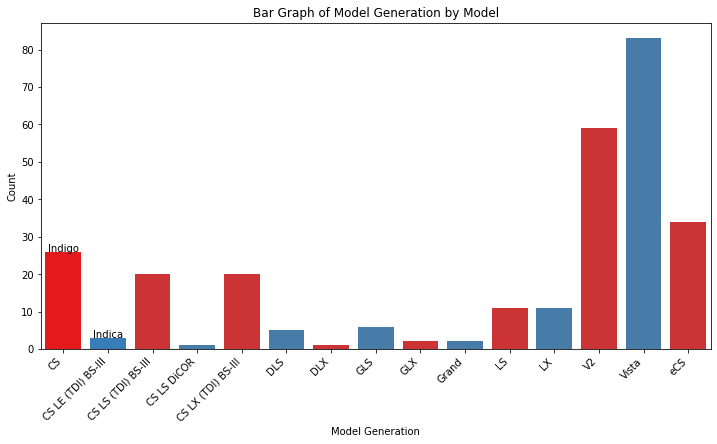

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each unique value in the 'model_gen' column
model_gen_counts = df['model_gen'].value_counts()

# Create a color map for 'model' field
colors = sns.color_palette("Set1", n_colors=len(df['model'].unique()))

# Create a bar graph with colors based on 'model'
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=model_gen_counts.index, y=model_gen_counts.values, palette=colors)
plt.title('Bar Graph of Model Generation by Model')
plt.xlabel('Model Generation')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility

# Add a legend for 'model' values
for patch, label in zip(ax.patches, df['model'].unique()):
    color = colors[df['model'].unique().tolist().index(label)]
    patch.set_facecolor(color)
    ax.text(patch.get_x() + patch.get_width() / 2, patch.get_height(), label, ha='center', color='black')

plt.show()


INCLUDE EXPLANATION
<br>
<br>
<br>
<br>
<br>
<br>
<br>



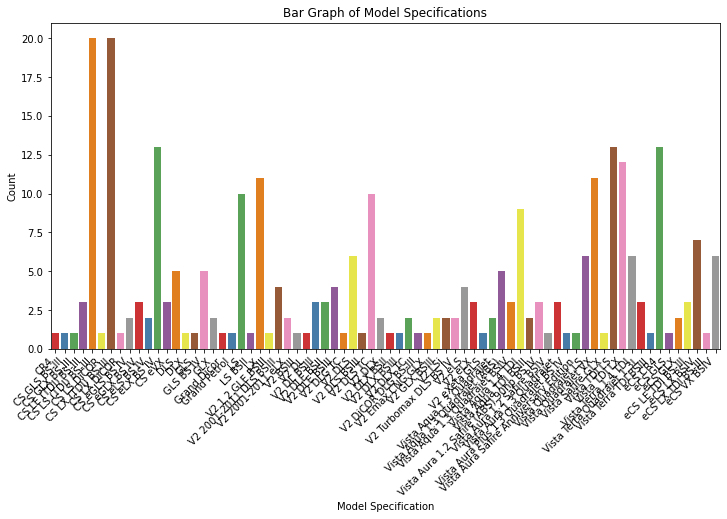

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each unique value in the 'model_spec' column
model_spec_counts = df['model_spec'].value_counts()

# Create a bar graph for 'model_spec'
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=model_spec_counts.index, y=model_spec_counts.values, palette="Set1")
plt.title('Bar Graph of Model Specifications')
plt.xlabel('Model Specification')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility

plt.show()

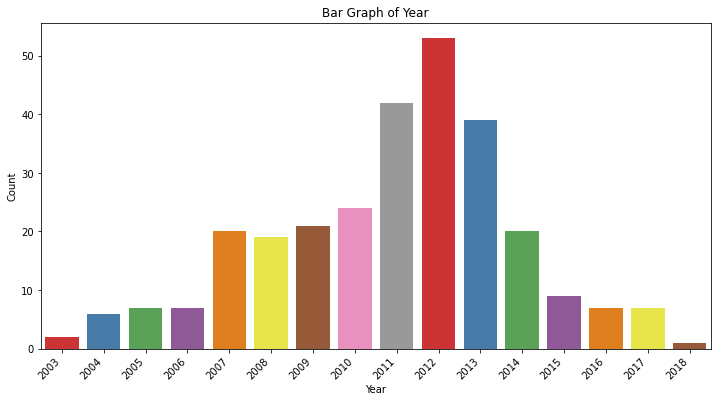

In [23]:
# Create a bar graph for 'year'
year_counts = df['year'].value_counts()
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=year_counts.index, y=year_counts.values, palette="Set1")
plt.title('Bar Graph of Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()


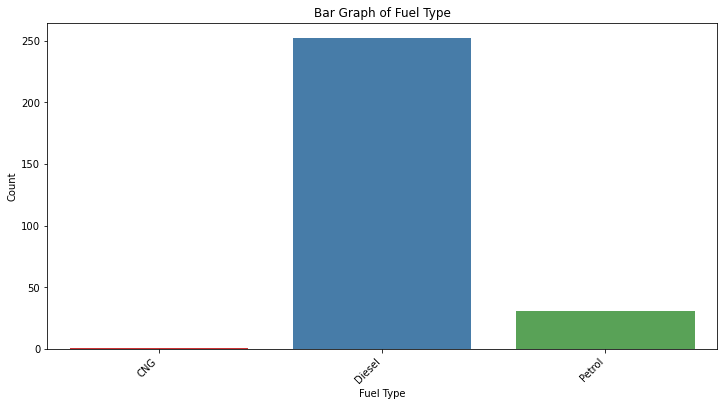

In [24]:
# Create a bar graph for 'fuel'
fuel_counts = df['fuel'].value_counts()
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=fuel_counts.index, y=fuel_counts.values, palette="Set1")
plt.title('Bar Graph of Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

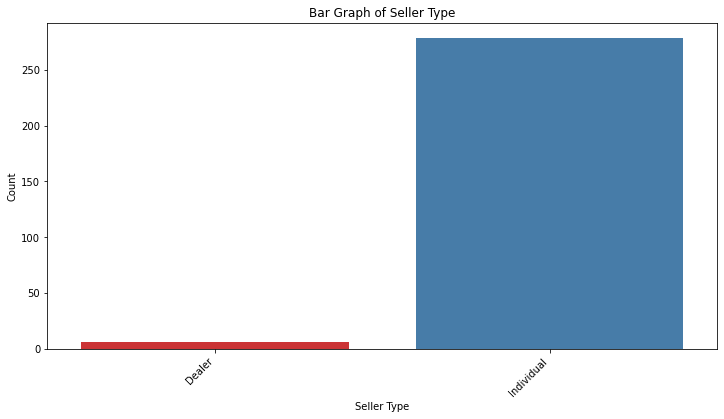

In [25]:
# Create a bar graph for 'seller_type'
seller_type_counts = df['seller_type'].value_counts()
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=seller_type_counts.index, y=seller_type_counts.values, palette="Set1")
plt.title('Bar Graph of Seller Type')
plt.xlabel('Seller Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

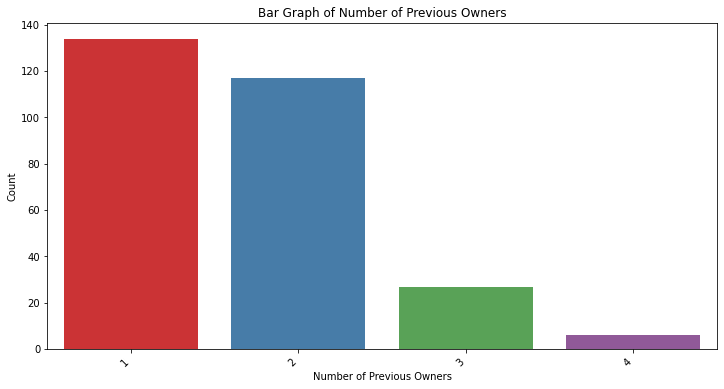

In [26]:
# Create a bar graph for 'num_previous_owners'
num_previous_owners_counts = df['num_previous_owners'].value_counts()
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=num_previous_owners_counts.index, y=num_previous_owners_counts.values, palette="Set1")
plt.title('Bar Graph of Number of Previous Owners')
plt.xlabel('Number of Previous Owners')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

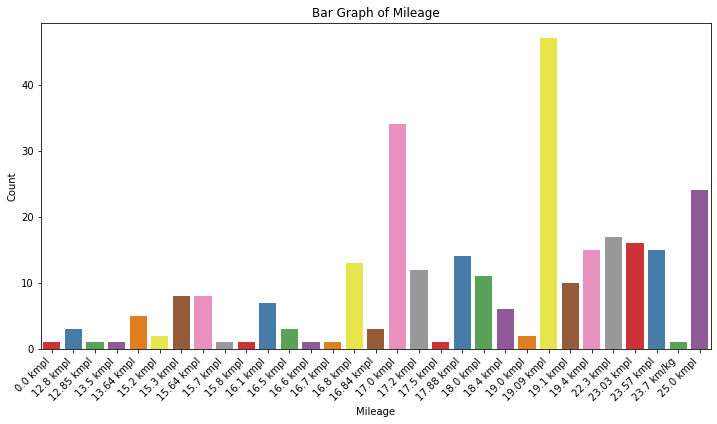

In [27]:
# Create a bar graph for 'mileage'
mileage_counts = df['mileage'].value_counts()
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=mileage_counts.index, y=mileage_counts.values, palette="Set1")
plt.title('Bar Graph of Mileage')
plt.xlabel('Mileage')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

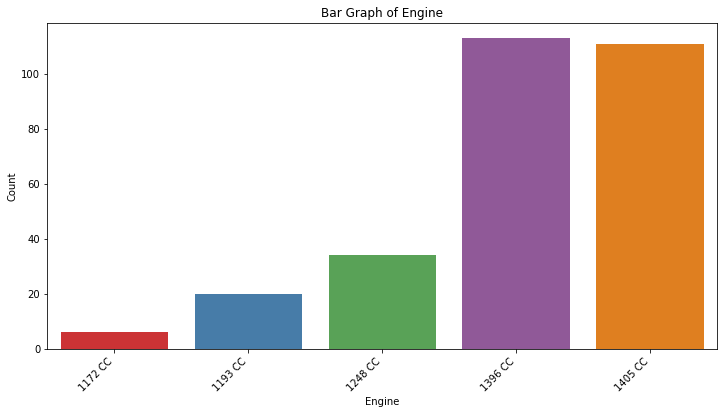

In [28]:
# Create a bar graph for 'engine'
engine_counts = df['engine'].value_counts()
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=engine_counts.index, y=engine_counts.values, palette="Set1")
plt.title('Bar Graph of Engine')
plt.xlabel('Engine')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

# Step 13: Outlier and Skewness Treatment

Outliers, specifically those observed in the modified boxplots, seller type, and fuel type visualizations were kept in with the data. One reason for this was the already limited number of observations.